<h1 style="color:dodgerblue"> 
ISEF 2024-25 Project
</h1>

<h3 style="color:black"> 
Assessing Effect of Change in Computational Complexity (Space and Time Variables) on Accuracy And Efficiency Of CSS Codes, Applied on Bell States
</h3>

##### <span style="color: black;"> By: Sumer Chaudhary, 9th Grade, BASIS Independent McLean
###### <span style="color: black;"> sumerchaudhary1@gmail.com

______________________
<h6 style="color:dodgerblue"> 
12/17/2024 - 01/26/2025
</h6>

## <span style="color: black;">Imports and Setup

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, generate_preset_pass_manager, transpile
from qiskit.visualization import plot_histogram, plot_circuit_layout
from qiskit.quantum_info import Statevector, Operator
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.circuit import IfElseOp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2
from control import create_bell_state
from shor import create_shor_bell_state
from steane import create_steane_bell_state
from fqc import create_fqc_bell_state

service=QiskitRuntimeService(channel="ibm_quantum")

In [2]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

qBackend = service.least_busy(simulator=False)

noise_model = NoiseModel.from_backend(qBackend)
simBackend = AerSimulator(noise_model=noise_model, method="matrix_product_state")

## <span style="color: black;">Creating Circuits

### <span style="color: black;"> Control Group

In [3]:
control_qc = create_bell_state()

#control_qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=False, filename="Diagrams/control.png")

### <span style="color: black;"> Shor's Error Correction Code

In [4]:
shor_qc = create_shor_bell_state()

#shor_qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=True, filename="Diagrams/shor.png")

### <span style="color: black;"> Steane Error Correction Code

In [5]:
steane_qc = create_steane_bell_state()

#steane_qc.draw("mpl", style="clifford", scale=0.75, fold=-1, plot_barriers=True, initial_state=True, justify="none", filename="Diagrams/steane.png")

### <span style="color: black;"> Five Qubit Error Correction Code

In [6]:
fqc_qc = create_fqc_bell_state()

#fqc_qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=True, justify="none", filename="Diagrams/five_qubit_code.png")

## <span style="color: black;">    Running experiments

### <span style="color: black;">Simulator

In [7]:
# Convert to an ISA circuit (circuit mapped to the backend's Information Set Architecture),
# and layout-mapped observables.
circuits = [control_qc, shor_qc, steane_qc, fqc_qc]
pm = generate_preset_pass_manager(backend=simBackend, optimization_level=3)
isa_circuits = [pm.run(circuit) for circuit in circuits]

In [8]:
#Run the ISA circuits
numShots = 250
jobs = [simBackend.run(circuit, shots=numShots) for circuit in isa_circuits]

In [9]:
results = []
time = []
for job in jobs:
    proc_results = {'00': 0, '01': 0, '10': 0, '11': 0}
    proc_time = {circuits[jobs.index(job)].name: job.result().time_taken}
    for res in job.result().get_counts(0):
        proc_results[res[:2]] += job.result().get_counts(0)[res]
    results.append(proc_results)
    time.append(proc_time)

print(results, "\n", time)

[{'00': 107, '01': 8, '10': 12, '11': 123}, {'00': 61, '01': 62, '10': 47, '11': 80}, {'00': 80, '01': 52, '10': 52, '11': 66}, {'00': 101, '01': 27, '10': 24, '11': 98}] 
 [{'Bell State Unencoded': 0.7096672058105469}, {"Bell State Encoded with Shor's Code": 401.93678522109985}, {"Bell State Encoded with Steane's Code": 252.62819480895996}, {'Bell State Encoded with the Five Qubit Code': 5.963917016983032}]


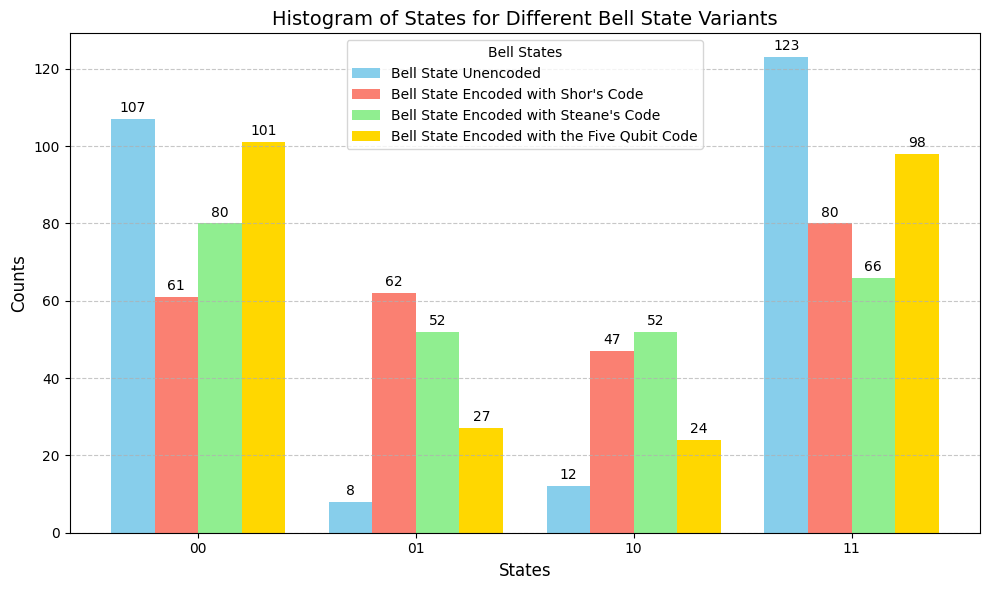

In [40]:
states = {}
for result in results:
    states[circuits[results.index(result)].name] = result
# Extract data
categories = list(next(iter(states.values())).keys())  # ['00', '01', '10', '11']
bar_width = 0.2  # Width of each bar
x = np.arange(len(categories))  # X positions for bars

# Define colors for each dataset
colors = ['skyblue', 'salmon', 'lightgreen', 'gold']
names = list(states.keys())  # Names of the datasets

# Plot the histogram
plt.figure(figsize=(10, 6))
for i, (name, counts) in enumerate(states.items()):
    counts_values = [counts[category] for category in categories]
    bar_positions = x + i * bar_width
    bars = plt.bar(bar_positions, counts_values, width=bar_width, label=name, color=colors[i])
    
    # Add text annotations above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 1,  # Slightly above the bar
            f'{int(height)}', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )


# Add labels, title, and legend
plt.xlabel('States', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of States for Different Bell State Variants', fontsize=14)
plt.xticks(x + bar_width * (len(states) - 1) / 2, categories, fontsize=10)  # Adjust x-ticks
plt.legend(title='Bell States', fontsize=10)

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig('Results/all.png')
plt.show()

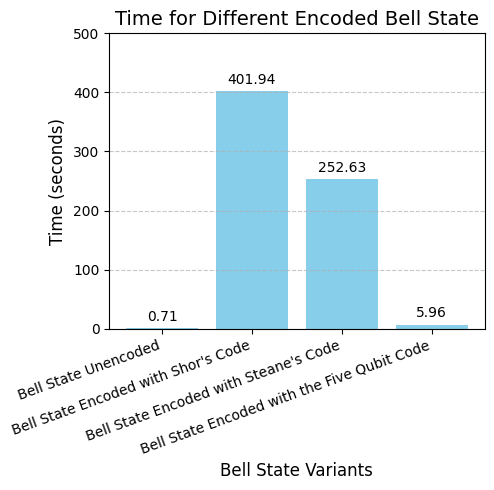

In [47]:
names = [list(item.keys())[0] for item in time]
times = [list(item.values())[0] for item in time]

# Plot the bar chart
plt.figure(figsize=(5, 5))  # Adjust size as needed
bars = plt.bar(names, times, color='skyblue')
plt.ylim(0, 500)  # Set max y-value to 500

# Add value annotations above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + max(times) * 0.02,  # Slightly above the bar
        f'{height:.2f}',  # Format the time with 2 decimal places
        ha='center', 
        va='bottom', 
        fontsize=10
    )

plt.ylim(0, 500)  # Set max y-value to 500

# Add labels and title
plt.xlabel('Bell State Variants', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time for Different Encoded Bell State', fontsize=14)
plt.xticks(rotation=20, ha='right', fontsize=10)  # Rotate labels for readability

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig('Results/time.png')
plt.show()
plt.close()


### <span style="color: black;"> Quantum Computer

In [7]:
# Convert to an ISA circuit and layout-mapped observables.
circuits = [control_qc, shor_qc, steane_qc, fqc_qc]
pm = generate_preset_pass_manager(backend=qBackend, optimization_level=3)
control_isa_circuit = pm.run(control_qc)
shor_isa_circuit = pm.run(shor_qc)
steane_isa_circuit = pm.run(steane_qc)
fqc_isa_circuit = pm.run(fqc_qc)

In [44]:
# Create a batch of jobs
with Batch(backend=qBackend):
    sampler = SamplerV2()
    
    #Run each circuit (maximum of three pending jobs, so I can only run these three, and then run the Five Qubit Code
    control_job = sampler.run(pubs=[control_isa_circuit], shots=1024)
    shor_job = sampler.run(pubs=[shor_isa_circuit], shots=1024)
    steane_job = sampler.run(pubs=[steane_isa_circuit], shots=1024)


print(f">>> Control Job ID: {control_job.job_id()}")
print(f">>> Shor Job ID: {shor_job.job_id()}")
print(f">>> Steane Job ID: {steane_job.job_id()}")

>>> Control Job ID: cy280rbcw2k0008jgkeg
>>> Shor Job ID: cy280sbnrmz0008569t0
>>> Steane Job ID: cy280t3nrmz0008569tg


In [45]:
#Get the results
control_result = control_job.result()
shor_result = shor_job.result()
steane_result = steane_job.result()

In [46]:
#print(steane_job.metrics()["usage"]["quantum_seconds"])
plot_histogram(control_result[0].data.measured_output.get_counts(), filename="QuantResults/control.png")
plot_histogram(shor_result[0].data.measured_output.get_counts(), filename="QuantResults/shor.png")
plot_histogram(steane_result[0].data.measured_output.get_counts(), filename="QuantResults/steane.png")

In [47]:
with Batch(backend=qBackend):
    sampler = SamplerV2()
    #Running control_job as well so that the time doesn't include startup time
    startup_control_job = sampler.run(pubs=[control_isa_circuit], shots=1024)
    fqc_job = sampler.run(pubs=[fqc_isa_circuit], shots=1024)

print(f">>> Five Qubit Code Job ID: {fqc_job.job_id()}")

>>> Five Qubit Code Job ID: cy282asrta1g0086qyxg


In [48]:
fqc_result = fqc_job.result()

In [49]:
plot_histogram(fqc_result[0].data.measured_output.get_counts(), filename="QuantResults/fqc.png")

In [50]:
jobs=[control_job, shor_job, steane_job, fqc_job]

In [15]:
results = []
time = []

for job in jobs:
    proc_results = {'00': 0, '01': 0, '10': 0, '11': 0}
    #proc_time = {circuits[jobs.index(job)].name: job.metrics()["usage"]["quantum_seconds"]}
    proc_time = {circuits[jobs.index(job)].name: job.usage_estimation['quantum_seconds']}
    for res in job.result()[0].data.measured_output.get_counts():
        proc_results[res[:2]] += job.result()[0].data.measured_output.get_counts()[res]
    results.append(proc_results)
    time.append(proc_time)

print(results, "\n", time)

[{'00': 496, '01': 4, '10': 11, '11': 513}, {'00': 239, '01': 258, '10': 252, '11': 275}, {'00': 304, '01': 231, '10': 244, '11': 245}, {'00': 240, '01': 318, '10': 203, '11': 263}] 
 [{'Bell State Unencoded': 2.153078783185507}, {"Bell State Encoded with Shor's Code": 3.356018261097973}, {"Bell State Encoded with Steane's Code": 3.056052435383051}, {'Bell State Encoded with the Five Qubit Code': 2.890074135689818}]


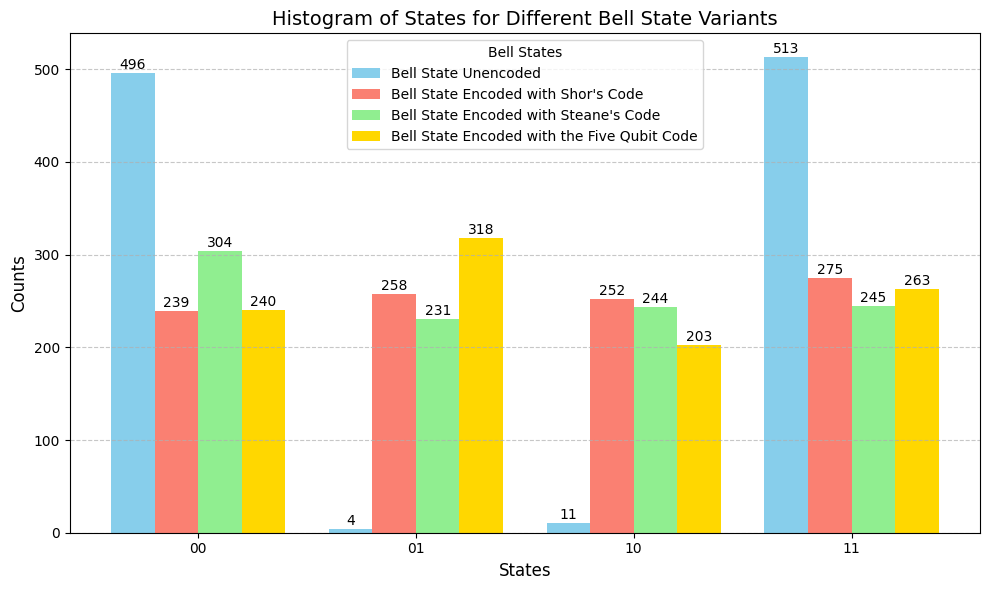

In [16]:
states = {}
for result in results:
    states[circuits[results.index(result)].name] = result
# Extract data
categories = list(next(iter(states.values())).keys())  # ['00', '01', '10', '11']
bar_width = 0.2  # Width of each bar
x = np.arange(len(categories))  # X positions for bars

# Define colors for each dataset
colors = ['skyblue', 'salmon', 'lightgreen', 'gold']
names = list(states.keys())  # Names of the datasets

# Plot the histogram
plt.figure(figsize=(10, 6))
for i, (name, counts) in enumerate(states.items()):
    counts_values = [counts[category] for category in categories]
    bar_positions = x + i * bar_width
    bars = plt.bar(bar_positions, counts_values, width=bar_width, label=name, color=colors[i])
    
    # Add text annotations above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 1,  # Slightly above the bar
            f'{int(height)}', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )


# Add labels, title, and legend
plt.xlabel('States', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of States for Different Bell State Variants', fontsize=14)
plt.xticks(x + bar_width * (len(states) - 1) / 2, categories, fontsize=10)  # Adjust x-ticks
plt.legend(title='Bell States', fontsize=10)

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig('QuantResults/all.png')
plt.show()

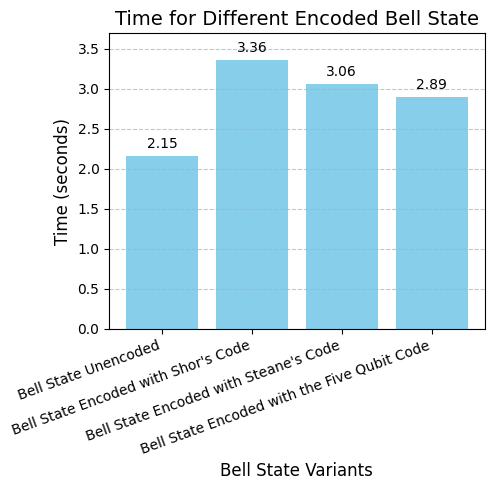

In [17]:
names = [list(item.keys())[0] for item in time]
times = [list(item.values())[0] for item in time]

# Plot the bar chart
plt.figure(figsize=(5, 5))  # Adjust size as needed
bars = plt.bar(names, times, color='skyblue')
plt.ylim(0, max(times)+max(times)/10)  # Set max y-value to 500

# Add value annotations above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + max(times) * 0.02,  # Slightly above the bar
        f'{height:.2f}',  # Format the time with 2 decimal places
        ha='center', 
        va='bottom', 
        fontsize=10
    )

# Add labels and title
plt.xlabel('Bell State Variants', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time for Different Encoded Bell State', fontsize=14)
plt.xticks(rotation=20, ha='right', fontsize=10)  # Rotate labels for readability

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig('QuantResults/time.png')
plt.show()
plt.close()

## <span style="color: black;">    Processing Results

In [7]:
jobs = [service.job("cy27xf5nrmz0008569pg"),service.job("cy27xfxrta1g0086qyng"), service.job("cy27xgprta1g0086qypg"), service.job("cy282asrta1g0086qyxg")] # Get the jobs. Replace these with the jobs on your end if you wish to run it on your end
circuits = [control_qc, shor_qc, steane_qc, fqc_qc] #Get the Circuits

In [8]:
names = ['Unencoded', 'Shor\'s Code', 'Steane\'s Code', 'Five-Qubit-Code'] #Names of the Circuits
results = {'Unencoded': {'00': 107, '01': 8, '10': 12, '11': 123}, "Shor's Code": {'00': 61, '01': 62, '10': 47, '11': 80}, "Steane's Code": {'00': 80, '01': 52, '10': 52, '11': 66}, 'Five-Qubit-Code': {'00': 101, '01': 27, '10': 24, '11': 98}} #These are the results I got from the simulator for anyone who wishes to run the code on their end. Make this an empty list if you want to use your jobs
errors = {} #Errors from the results (times deviated from 00 or 11)
times = {} #Length it took to run
depths = {} #Number of gates in the circuit
num_qubits = {} #Number of qubits in the circuit
for job in jobs:
    errors[names[jobs.index(job)]] = (results[names[jobs.index(job)]]['01'] + results[names[jobs.index(job)]]['10'])/(results[names[jobs.index(job)]]['00'] + results[names[jobs.index(job)]]['01'] + results[names[jobs.index(job)]]['10'] + results[names[jobs.index(job)]]['11'])*100 #Get the number of times deviated from the correct values (00 or 11) and convert it into a percentage
    times[names[jobs.index(job)]] = job.usage_estimation['quantum_seconds'] #Get the time fo the job
    depths[names[jobs.index(job)]] =  circuits[jobs.index(job)].depth() #Get the depth of the pre-optimized circuit
    num_qubits[names[jobs.index(job)]] = circuits[jobs.index(job)].num_qubits #Get the number of qubits

print(results, "\n", times, "\n", errors, "\n", depths, "\n", num_qubits) #For debugging

{'Unencoded': {'00': 107, '01': 8, '10': 12, '11': 123}, "Shor's Code": {'00': 61, '01': 62, '10': 47, '11': 80}, "Steane's Code": {'00': 80, '01': 52, '10': 52, '11': 66}, 'Five-Qubit-Code': {'00': 101, '01': 27, '10': 24, '11': 98}} 
 {'Unencoded': 2.153078783185507, "Shor's Code": 3.356018261097973, "Steane's Code": 3.056052435383051, 'Five-Qubit-Code': 2.890074135689818} 
 {'Unencoded': 8.0, "Shor's Code": 43.6, "Steane's Code": 41.6, 'Five-Qubit-Code': 20.4} 
 {'Unencoded': 3, "Shor's Code": 100, "Steane's Code": 92, 'Five-Qubit-Code': 94} 
 {'Unencoded': 2, "Shor's Code": 36, "Steane's Code": 28, 'Five-Qubit-Code': 20}


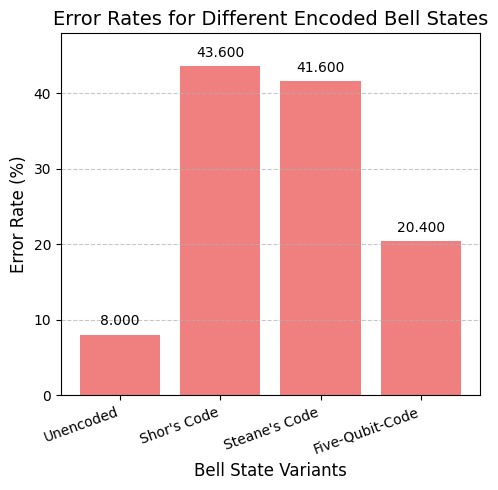

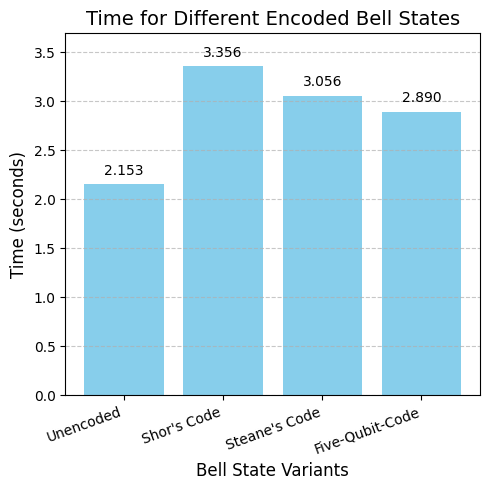

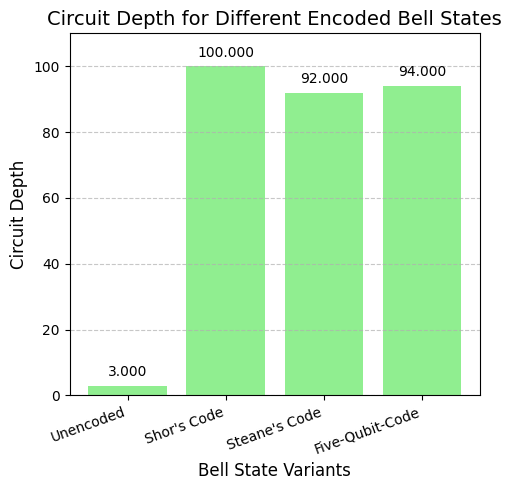

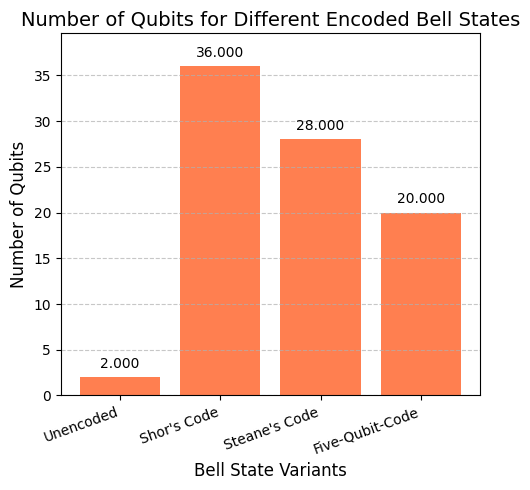

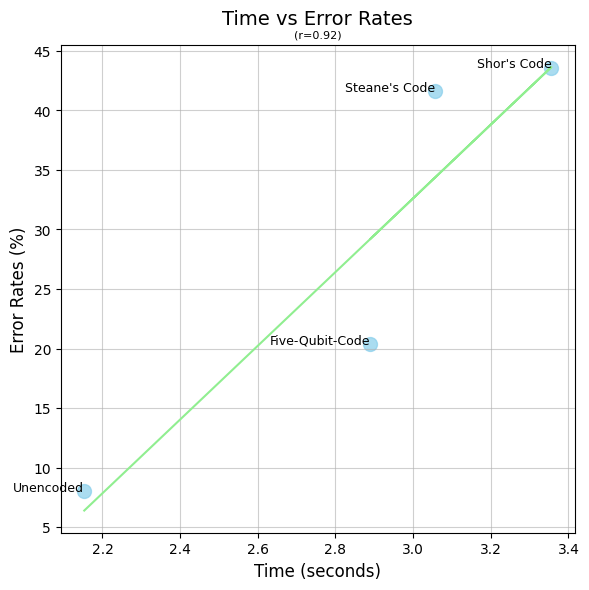

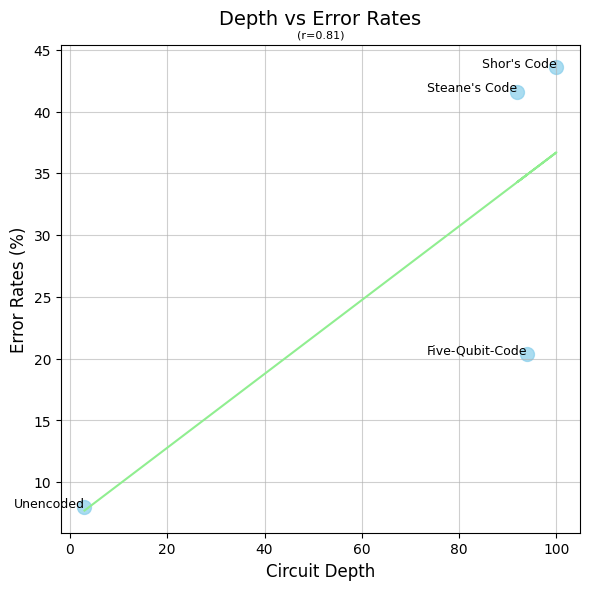

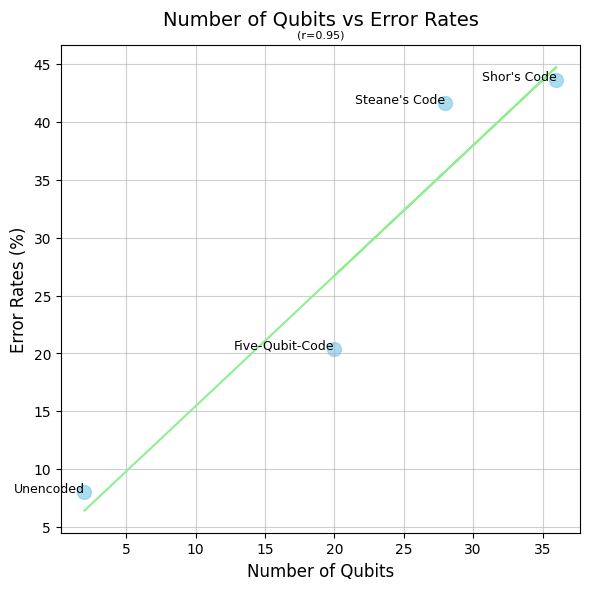

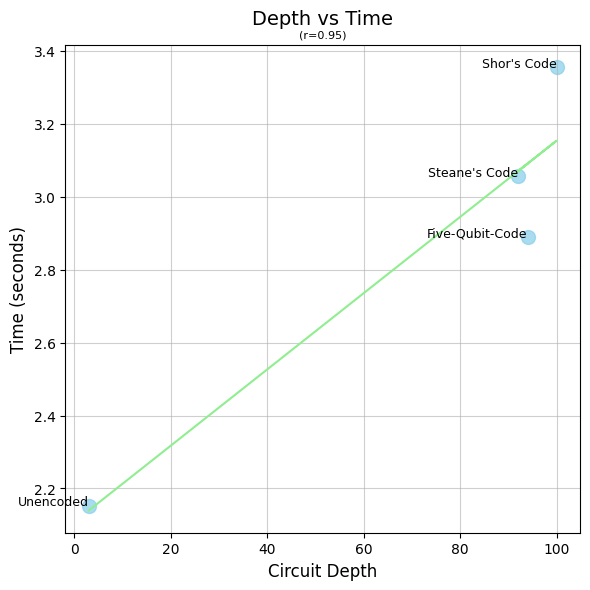

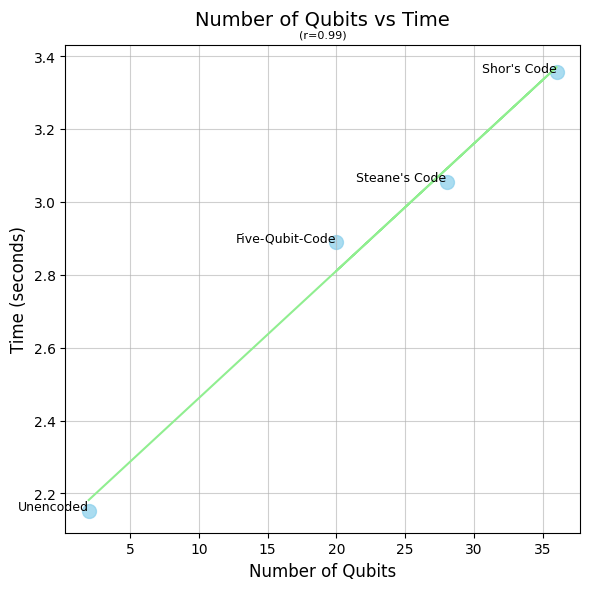

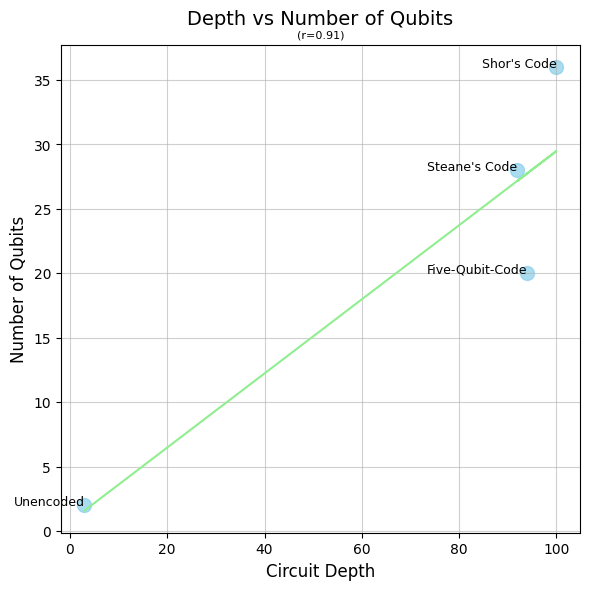

In [12]:
# Extract names and values
def extract_keys_values(dictionary):
    return list(dictionary.keys()), list(dictionary.values())

names, times_values = extract_keys_values(times)
_, error_values = extract_keys_values(errors)
_, depth_values = extract_keys_values(depths)
_, num_qubit_values = extract_keys_values(num_qubits)

def plot_histogram(values, color, y_name, table_name):
    # Plot histogram for error rates
    plt.figure(figsize=(5, 5))
    bars = plt.bar(names, values, color=color)
    plt.ylim(0, max(values) + max(values) / 10)
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + max(values) * 0.02,
            f'{height:.3f}',
            ha='center',
            va='bottom',
            fontsize=10
        )
    plt.xlabel('Bell State Variants', fontsize=12)
    plt.ylabel(y_name, fontsize=12)
    plt.title(table_name, fontsize=14)
    plt.xticks(rotation=20, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"QuantResults/{table_name}.png")
    plt.show()
    plt.close()


plot_histogram(error_values, 'lightcoral', 'Error Rate (%)', 'Error Rates for Different Encoded Bell States')

plot_histogram(times_values, 'skyblue', 'Time (seconds)', 'Time for Different Encoded Bell States')

plot_histogram(depth_values, 'lightgreen', 'Circuit Depth', 'Circuit Depth for Different Encoded Bell States')

plot_histogram(num_qubit_values, 'coral', 'Number of Qubits', 'Number of Qubits for Different Encoded Bell States')

# Plot scatter plots
relationships = [
    (times_values, error_values, 'Time (seconds)', 'Error Rates (%)', 'Time vs Error Rates'),
    (depth_values, error_values, 'Circuit Depth', 'Error Rates (%)',  'Depth vs Error Rates'),
    (num_qubit_values, error_values, 'Number of Qubits', 'Error Rates (%)', 'Number of Qubits vs Error Rates'),
    (depth_values, times_values, 'Circuit Depth', 'Time (seconds)', 'Depth vs Time'),
    (num_qubit_values, times_values, 'Number of Qubits', 'Time (seconds)', 'Number of Qubits vs Time'),
    (depth_values, num_qubit_values, 'Circuit Depth', 'Number of Qubits', 'Depth vs Number of Qubits')
]

for x_values, y_values, xlabel, ylabel, title in relationships:
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)
    # Line of regression (y = mx + b)
    regression_line = slope * np.array(x_values) + intercept
    
    plt.figure(figsize=(6, 6))
    
    plt.scatter(x_values, y_values, color='skyblue', s=100, alpha=0.7)
    # Plot the regression line
    plt.plot(x_values, regression_line, color='lightgreen')
    for i, name in enumerate(names):
        plt.text(x_values[i], y_values[i], name, fontsize=9, ha='right')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14, y= 1.025)
    
    plt.text(x=.5, y=1.02, s=f'(r={r_value:.2f})', ha='center', va='center', fontsize=8, transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.grid(alpha=0.6)
    plt.savefig(f"QuantResults/{title}.png")
    plt.show()
    plt.close()